# Noisy Cepheids

***Tasks***

1. You're observing a [Cepheid](https://en.wikipedia.org/wiki/Cepheid_variable) variable star, which is a source with an intrinsic (and presumably smooth) variability.  
2. Measure its period (that's crucial for [cosmology](https://en.wikipedia.org/wiki/Hubble%27s_law)!)
3. Estimate the error on your measurement.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
import emcee
from scipy import stats
import warnings; warnings.simplefilter('ignore')
import corner
import scipy
from sklearn.model_selection import GridSearchCV

Let's supose that we have 3 detectors observing the same Cepheid star. Cepheids generally show periodicity in their flux, but this time the detectors were so noisy that you cannot understand the period "by eye". In this case a decomposition of the signal is necessary to separate the true signal emitted by the star from the detector noise.

(2000, 3)


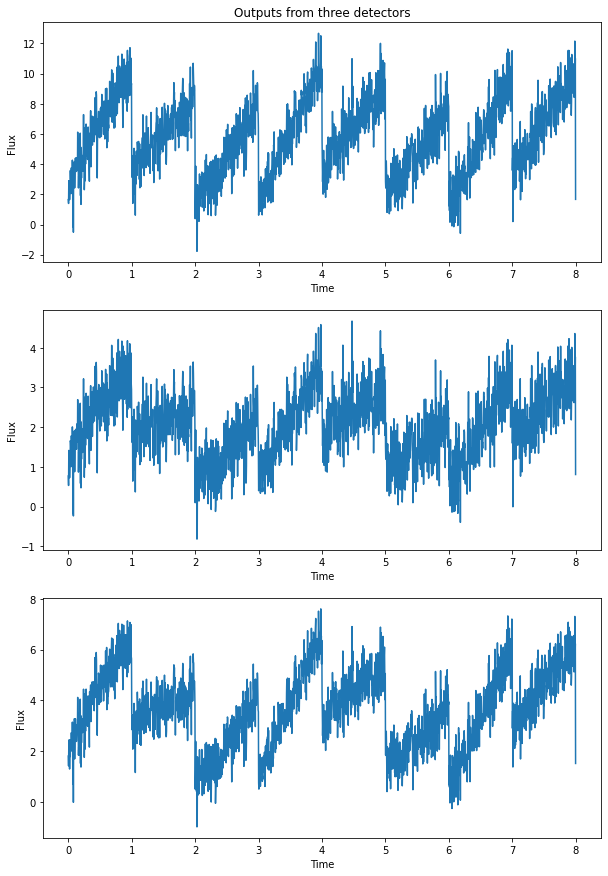

In [2]:
#loading the data and plotting the signals from the detectors

X=np.load('noisydetector.npy')      #import data

time = np.linspace(0, 8, X.shape[0])
print(X.shape)
fig, ax = plt.subplots(3,figsize=(10,15))
ax[0].set_title('Outputs from three detectors')

for ax,s in zip(ax,X.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
    ax.set_ylabel('Flux')

### ICA

For this type of analysis ICA seems to be the preferred method, since it maximises the independency between different components.

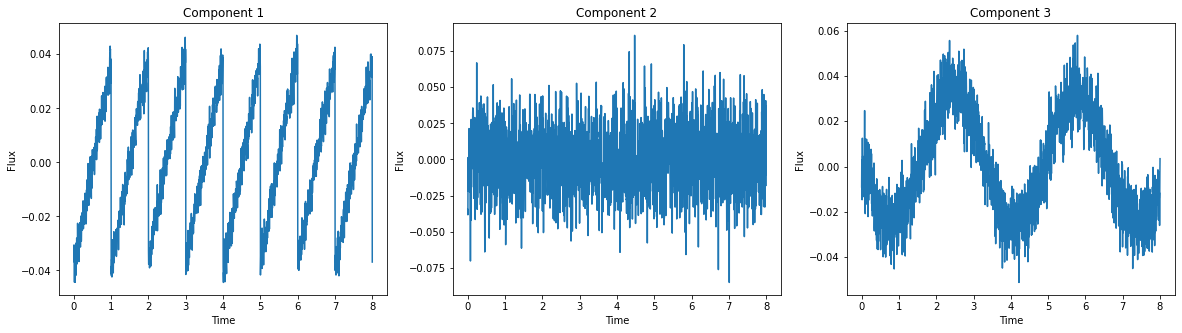

In [3]:
#let's try with ICA
ica = FastICA(3)
ica.fit(X)
channels = ica.transform(X)    #(2000x3) (for each instant of time I have 3 attributes)
comp = ica.components_         #(3x3) 

fig, ax = plt.subplots(1,3, figsize=(20,5))
for i in range(3):
    ax[i].plot(time, channels[:,i])
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Flux')    
    ax[i].set_title('Component %.0f' %(i+1))

There are two components made of noise: a kind of "white noise" and a more periodic one. The sinusoidal signal is now clearly visible.

What if we do the same with PCA?

### PCA (n_comp = 2)

In [4]:
#finding how many dimensions are needed to have an accuracy of 99.5%

pca995 = PCA(n_components=0.995) #when n_comp is <1 it's the n_comp such that the variance is this!
pca995.fit(X)
print("{:d} features are needed to explain 99.5% of the variance".format(pca995.n_components_))

2 features are needed to explain 99.5% of the variance


In [5]:
#Setting 2 components and finding the variance
pca = PCA(n_components = 2)
pca.fit(X)
print('Variance with 2 components: ', np.sum(pca.explained_variance_ratio_))

Variance with 2 components:  0.9953621436374218


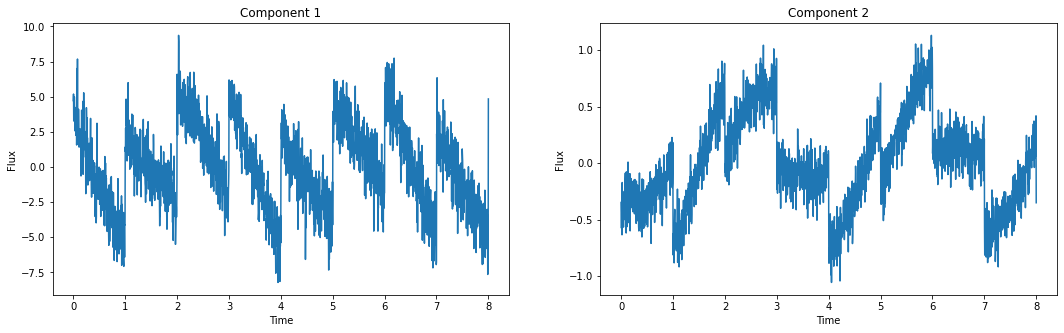

In [6]:
trans = pca.transform(X)  
mean = pca.mean_                   # mean of the data
comp = pca.components_    # finding the eigenvectors (n_comp, n_features)

fig, ax = plt.subplots(1,2, figsize=(18,5))

for i in range(2):
    ax[i].plot(time, trans[:,i])
    ax[i].set_title('Component %.0f' %(i+1))
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Flux')

These are the two components that describe the 99% of the signal. As we can see even if they can describe most of the data, they're not highlighting any sinusoidal behaviour, that can be found only with ICA imposing the maximum independency between the components.

### FItting

Text(0.5, 1.0, 'Sinusoidal component from ICA')

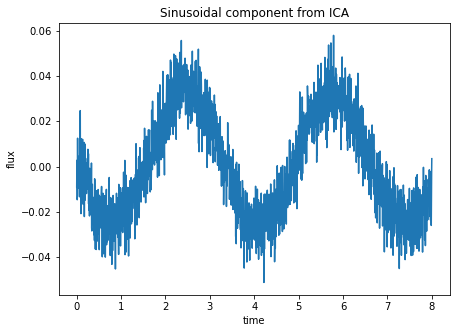

In [11]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(time, channels[:,2])

ax.set_xlabel('time')
ax.set_ylabel('flux')
ax.set_title('Sinusoidal component from ICA')

Now, let's try to understand something about the periodicity of these stars. Here I first perform a frequentist fit comparing the results from the minimization of chi-squared implemented by me, with the results from scipy fitting algorithm.

Optimization terminated successfully.
         Current function value: 0.173265
         Iterations: 80
         Function evaluations: 146

Results from manual chi-squared minimization:  [ 0.02832325  1.89367736 -0.84989477]
Results from scipy curve-fitting:  [ 0.02832261  1.89365622 -0.84991876]  +-  [0.00029139 0.00469606 0.01301458]


Text(-0.02, 0.05, 'T = 3.318 $\\pm$ 0.008')

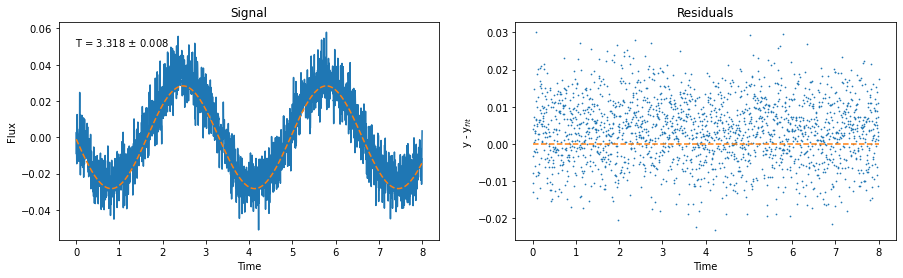

In [12]:
#Fit: freuentist method
fig, ax = plt.subplots(1,2, figsize=(15,4))

periodicity = channels[:,2] 
ax[0].plot(time, periodicity)

#defining the chi-squared function as (y-y_fit)^2
def chi_squared(par, x, y):
    yfit = par[0]*np.cos(par[1]*(x-par[2]))
    return np.sum(((y-yfit))**2)

from scipy import optimize
funl = lambda par: chi_squared(par, x=time, y=periodicity)

in_par=(0.04, 2, -1) #initial guesses
lin_par = optimize.fmin(funl, in_par) #minimizing the chi-squared
print('\nResults from manual chi-squared minimization: ', lin_par)

ax[0].plot(np.linspace(0,8,500), lin_par[0]*np.cos(lin_par[1]*(np.linspace(0,8,500) - lin_par[2])), c='tab:orange', ls='--')
ax[1].scatter(time, periodicity-lin_par[0]*np.cos(lin_par[1]*(time - lin_par[2])), s=0.5)
ax[1].plot(np.linspace(0,8,500), np.linspace(0,8,500)*0+0, c='tab:orange', ls='--')

#frequentist with scipy.optimize
def sinusoidal(x, a, w, x0):
    return a*np.cos(w*(x-x0))
popt, pcov = scipy.optimize.curve_fit(sinusoidal, time, periodicity, p0=in_par)
parerr = np.sqrt(np.diag(pcov))

print( 'Results from scipy curve-fitting: ', popt, ' +- ', parerr)

T = 2*np.pi/popt[1]
T_err = 2*np.pi/popt[1]**2*parerr[1]

for i in range(2):
    ax[i].set_xlabel('Time')

ax[0].set_ylabel('Flux')
ax[1].set_ylabel('y - y$_{fit}$')
ax[1].set_title('Residuals')
ax[0].set_title('Signal')
ax[0].text(-0.02, 0.05,'T = %.3f $\pm$ %.3f' %(T, T_err), fontsize=10)

The results are very similar! From the parameter $\omega$ I can find the period and the error on the period as:

$$T = \frac{2 \pi}{\omega}$$

$$\delta T = - \frac{2 \pi}{\omega^2} \delta \omega$$

The resulting period is: $T = 3.318 \pm 0.008$.

However minimizing the $\chi^2$ function to find the best parameters is possible when the uncertainties are normally distributed, because only in this case it the maximization of the Likelihood and the minimization of $\chi^2$ are equivalent. In the plot below I show that the deviations $y-y_{fit}$ are actually distributed as a normal function.

Text(0.5, 0, 'y-y$_{fit}$')

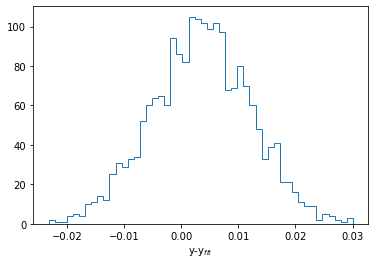

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
res = periodicity-lin_par[0]*np.cos(lin_par[1]*(time - lin_par[2]))
ax.hist(res, bins=50, histtype='step')
ax.set_xlabel('y-y$_{fit}$')

To convince ourselves that the residuals distribution could be seen as a Gaussian, we can run a KS test to compare our samples with the normal distribution with mean and standard deviation found from the samples. Here the p-value is very high, therefore the null hypothesis of the Gaussian distribution cannot be rejected.

In [14]:
from scipy.stats import kstest
from scipy.stats import norm
ks = kstest(res, 'norm', args=[np.mean(res), np.std(res)])
print(ks)

KstestResult(statistic=0.01147987375898829, pvalue=0.9519740874975184)
